In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

def generate_asset_prices(S0, r, sigma, T, M, N):
    """
    Generate asset price paths using geometric Brownian motion.

    Parameters:
    - S0: Initial stock price
    - r: Risk-free interest rate
    - sigma: Volatility of the underlying asset
    - T: Time to maturity
    - M: Number of time steps
    - N: Number of simulated paths

    Returns:
    - A numpy array of shape (N, M+1) containing the simulated asset prices
    """
    dt = T / M
    t = np.linspace(0, T, M+1)
    dW = np.sqrt(dt) * np.random.randn(N, M)
    W = np.cumsum(dW, axis=1)
    W = np.hstack((np.zeros((N, 1)), W))
    exponent = (r - 0.5 * sigma ** 2) * t + sigma * W
    S = S0 * np.exp(exponent)
    return S

def price_american_put_longstaff_schwartz(S0, K, r, sigma, T, M, N):
    """
    Price an American put option using the Longstaff-Schwartz method.

    Parameters:
    - S0: Initial stock price
    - K: Strike price
    - r: Risk-free interest rate
    - sigma: Volatility of the underlying asset
    - T: Time to maturity
    - M: Number of time steps
    - N: Number of simulated paths

    Returns:
    - Estimated option price
    """
    dt = T / M
    discount_factor = np.exp(-r * dt)

    # Generate asset price paths
    S = generate_asset_prices(S0, r, sigma, T, M, N)

    # Initialize cash flows
    cash_flows = np.maximum(K - S[:, -1], 0)

    # Loop backward in time
    for t in range(M - 1, 0, -1):
        # Indices of paths where the option is in the money
        in_the_money = np.where(K - S[:, t] > 0)[0]

        if len(in_the_money) == 0:
            continue

        # Prepare regression
        X = S[in_the_money, t]
        Y = cash_flows[in_the_money] * discount_factor

        # Basis functions (e.g., polynomials)
        A = np.vstack([np.ones_like(X), X, X**2]).T

        # Perform linear regression to estimate continuation values
        coeffs = np.linalg.lstsq(A, Y, rcond=None)[0]
        continuation_values = A @ coeffs

        # Immediate exercise value
        exercise_values = K - X

        # Decide whether to exercise
        exercise = exercise_values > continuation_values

        # Update cash flows
        cash_flows[in_the_money[exercise]] = exercise_values[exercise]
        cash_flows[in_the_money[~exercise]] *= discount_factor

    # Discount cash flows to present value
    option_price = np.mean(cash_flows * np.exp(-r * dt))

    return option_price



Estimated American put option price: 2.3332


In [18]:
# Parameters
S0 = 40       # Initial stock price
K = 40        # Strike price
r = 0.06      # Risk-free interest rate
sigma = 0.2   # Volatility
T = 1.0       # Time to maturity
M = 100        # Number of time steps
N = 100000    # Number of simulated paths

# Calculate option price
option_price = price_american_put_longstaff_schwartz(S0, K, r, sigma, T, M, N)
print(f"Estimated American put option price: {option_price:.4f}")


Estimated American put option price: 2.3189


In [9]:

dt = T / M
discount_factor = np.exp(-r * dt)

# Generate asset price paths
S = generate_asset_prices(S0, r, sigma, T, M, N)

# Initialize cash flows
cash_flows = np.maximum(K - S[:, -1], 0)

# Loop backward in time
for t in range(M - 1, 0, -1):
    # Indices of paths where the option is in the money
    in_the_money = np.where(K - S[:, t] > 0)[0]

    if len(in_the_money) == 0:
        continue

    # Prepare regression
    X = S[in_the_money, t]
    Y = cash_flows[in_the_money] * discount_factor

    # Basis functions (e.g., polynomials)
    A = np.vstack([np.ones_like(X), X, X**2]).T

    # Perform linear regression to estimate continuation values
    coeffs = np.linalg.lstsq(A, Y, rcond=None)[0]
    continuation_values = A @ coeffs

    # Immediate exercise value
    exercise_values = K - X

    # Decide whether to exercise
    exercise = exercise_values > continuation_values

    # Update cash flows
    cash_flows[in_the_money[exercise]] = exercise_values[exercise]
    cash_flows[in_the_money[~exercise]] *= discount_factor

# Discount cash flows to present value
option_price = np.mean(cash_flows * np.exp(-r * dt))

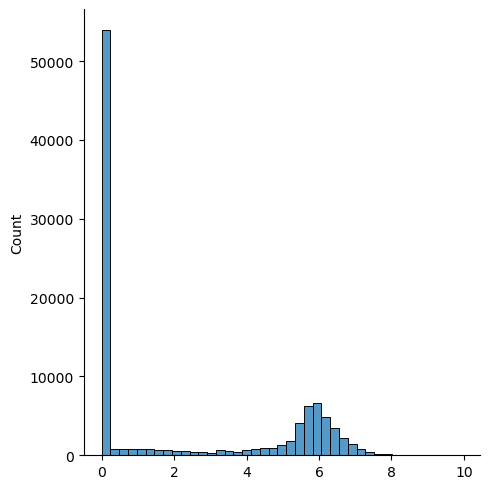

In [14]:
sns.displot(cash_flows)

In [7]:
option_price

2.32745853667639

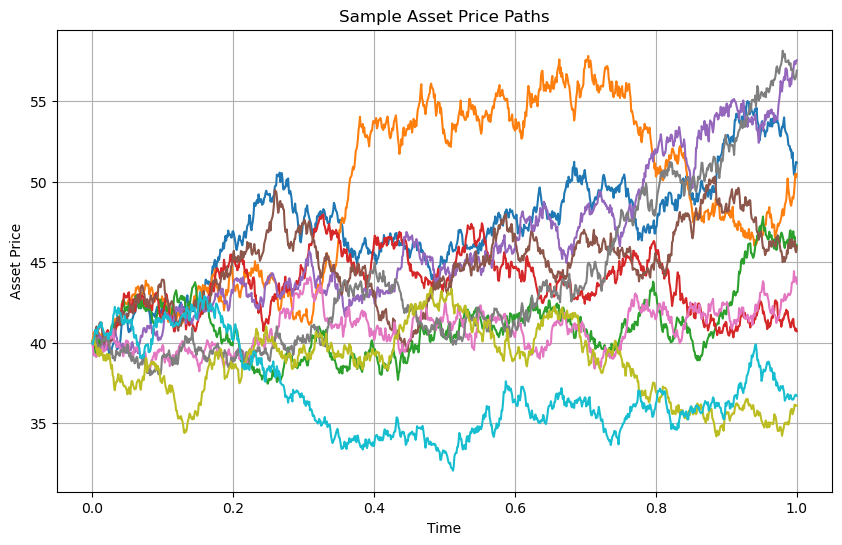

In [20]:
plt.figure(figsize=(10, 6))
M = 1000
S = generate_asset_prices(S0, r, sigma, T, M, N)
for i in range(10):  # Plot 10 sample paths
    plt.plot(np.linspace(0, T, M+1), S[i])
plt.title('Sample Asset Price Paths')
plt.xlabel('Time')
plt.ylabel('Asset Price')
plt.grid(True)
plt.show()